 **Comparing three state-of-the-art AI Tool for Detecting Security Bugs in Web Applications**

Saving thesisdataset.csv to thesisdataset (1).csv

Total Dataset: 1262

Vulnerable (Bad) (1): 727 / 1262

Safe (Good)(0): 535 / 1262




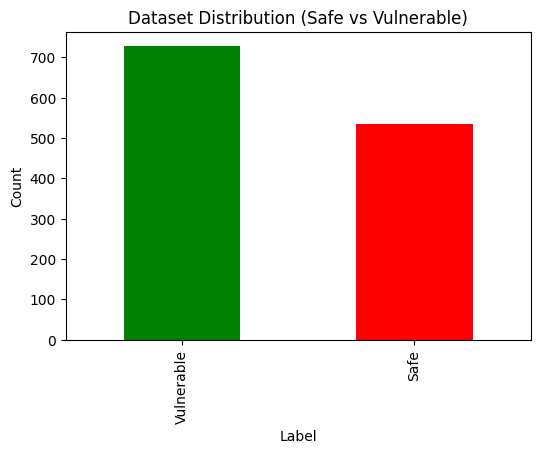


Vulnerability Breakdown (All Predictions):

SQLi: 188 / 1262
XSS: 213 / 1262
BufferOverflow: 379 / 1262
Safe: 482 / 1262




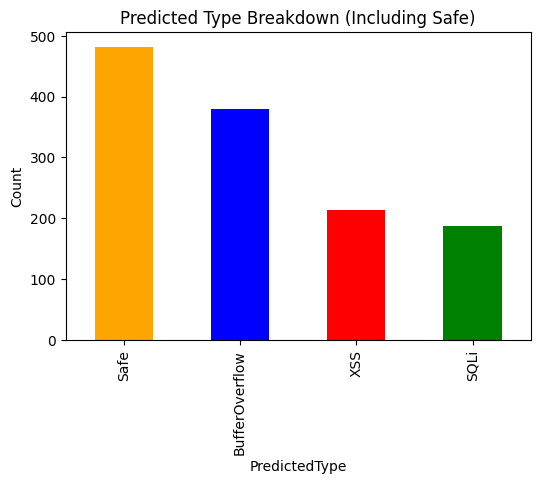


Confusion Matrix (Code Segments)(rows=true, cols=pred):
[[363 172]
 [119 608]]

 Classification Report (Bad And Good)
                precision    recall  f1-score   support

      Safe (0)       0.75      0.68      0.71       535
Vulnerable (1)       0.78      0.84      0.81       727

      accuracy                           0.77      1262
     macro avg       0.77      0.76      0.76      1262
  weighted avg       0.77      0.77      0.77      1262


Code Segment counts 
 True Positive (TP)=608, 
 False Positive (FP)=172, 
 True Negative (TN)=363, 
 False Negative (FN)=119

AI Model (Logistic Regression) Results
Classification Report:
                 precision    recall  f1-score   support

      Safe (0)       1.00      0.93      0.96       111
Vulnerable (1)       0.95      1.00      0.97       142

      accuracy                           0.97       253
     macro avg       0.97      0.96      0.97       253
  weighted avg       0.97      0.97      0.97       253

Training + In

In [2]:
from google.colab import files
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


uploaded = files.upload()

file_name = list(uploaded.keys())[0]

df = pd.read_csv(file_name)

def detect_sql_inj(code: str) -> bool:

    if not isinstance(code, str):
      return False

    s = code.lower()

    indicators = [

        "union select", " or 1=1", " or '1'='1", "drop table", "information_schema",
        "sleep(", "benchmark(", "load_file(", "concat(", "exec(", "sp_executesql",
        "into outfile", "outfile"
    ]

    for ind in indicators:
        if ind in s:

          return True

    if re.search(r"['\"].{0,20}--", s) or re.search(r"--\s*$", s):
      return True

    if re.search(r"\b(or|and)\b\s+\d+\s*=\s*\d+", s):
      return True

    if re.search(r"\bunion\b.*\bselect\b", s):
      return True

    return False

def detect_xss(code: str) -> bool:

    if not isinstance(code, str):
      return False

    s = code.lower()

    if "<script" in s or "javascript:" in s or "document.cookie" in s:
      return True

    if re.search(r"on\w+\s*=", s) and ("<" in s or ">" in s):
      return True

    if re.search(r"<[^>]*alert\s*\(", s):
      return True

    if re.search(r"<img[^>]*onerror\s*=", s):
      return True

    return False

def detect_buffer_over(code: str) -> bool:

    if not isinstance(code, str):
      return False

    s = code.lower()

    if re.search(r"\bchar\s+\w+\s*\[\s*\d+\s*\]", s):
      return True

    if re.search(r"\b(strcpy|strcat|gets|sprintf|scanf)\s*\(", s):
      return True

    return False

def predict_type(code: str) -> str:

    if detect_sql_inj(code):
      return "SQLi"

    if detect_xss(code):
      return "XSS"

    if detect_buffer_over(code):
      return "BufferOverflow"

    return "Safe"


start_time = time.time()

df["PredictedType"] = df["Sentence"].apply(predict_type)

df["PredictedBinary"] = df["PredictedType"].apply(lambda x: 1 if x != "Safe" else 0)

end_time = time.time()

runtime = end_time - start_time


total = len(df)
vuln_count = int(df["Label"].sum())
safe_count = total - vuln_count

print(f"\nTotal Dataset: {total}")
print(f"\nVulnerable (Bad) (1): {vuln_count} / {total}")
print(f"\nSafe (Good)(0): {safe_count} / {total}")

print(f"\n")
plt.figure(figsize=(6,4))
df["Label"].replace({0:"Safe",1:"Vulnerable"}).value_counts().plot(kind="bar", color=["green","red"])
plt.title("Dataset Distribution (Safe vs Vulnerable)")
plt.ylabel("Count")
plt.show()


type_counts = df["PredictedType"].value_counts().to_dict()

print(f"\nVulnerability Breakdown (All Predictions):\n")
for t in ["SQLi", "XSS", "BufferOverflow", "Safe"]:
    print(f"{t}: {type_counts.get(t,0)} / {len(df)}")

print(f"\n")

plt.figure(figsize=(6,4))
df["PredictedType"].value_counts().plot(kind="bar", color=["orange","blue","red","green"])
plt.title("Predicted Type Breakdown (Including Safe)")
plt.ylabel("Count")
plt.show()




y_true = df["Label"]
y_pred = df["PredictedBinary"]
cm = confusion_matrix(y_true, y_pred)

print("\nRegex Baseline Confusion Matrix (rows=true, cols=pred):")
print(cm)

print("\n Classification Report (Bad And Good)")

print(classification_report(y_true, y_pred, target_names=["Safe (0)", "Vulnerable (1)"]))


TN, FP, FN, TP = cm.ravel()
print(f"\nCode Segment counts \n True Positive (TP)={TP}, \n False Positive (FP)={FP}, \n True Negative (TN)={TN}, \n False Negative (FN)={FN}")


X = df["Sentence"].astype(str)
y = df["Label"]


vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


clf = LogisticRegression(max_iter=1000)
start_ai = time.time()
clf.fit(X_train, y_train)
y_pred_ai = clf.predict(X_test)
end_ai = time.time()
ai_runtime = end_ai - start_ai

print("\nAI Model (Logistic Regression)")
print("Classification Report:\n", classification_report(y_test, y_pred_ai, target_names=["Safe (0)","Vulnerable (1)"]))
print(f"Training + Inference Runtime: {ai_runtime:.4f} sec for {X_test.shape[0]} test samples")


print("\nTime Complexity Analysis")
print("Theoretical: O(m × n), where m = number of samples, n = average snippet length.")
print(f"Empirical runtime: {runtime:.4f} seconds for {total} samples.")
print(f"Average time per sample: {runtime/total:.6f} seconds.")
